# 模型选择 欠拟合和过拟合
## 模型选择
也就是如何选择超参数

训练误差：模型在训练数据上的误差

泛化误差：模型在新数据上的误差

我们更加关心泛化误差，而不是训练误差

训练数据集：用来训练模型参数

验证数据集：一个用来评估模型好坏的数据集：用来选择模型超参数
- 例如拿出50%的训练数据
- 不要和训练数据混在一起（常犯错误）

测试数据集：只用一次的数据集，不能用它调整超参数。

K-折交叉验证
- 在没有足够多数据时使用（这是常态）
- 算法：
  - 将训练数据分割成K块
  - For i = 1, ... , K
    - 使用第i块作为验证数据集，其他作为训练数据集
  - 报告K个验证集误差的平均
- 常用K = 5或者10

## 欠拟合和过拟合
### 模型容量
- 拟合各种函数的能力
- 低容量的模型难以拟合训练数据
- 高容量的模型可以记住所有训练数据

模型容量首先要足够大，然后通过调整，来降低过拟合的程度。

### VC维
统计学习理论的一个核心思想

对于一个分类模型，VC等于一个最大的数据集的大小，不管如何给定标号，都存在一个模型来对他进行完美分类。

例如：二维数据的感知机，VC维是3

支持N维输入的感知机的VC维是N+1

一些多层感知机的VC维$O(N\log_2N)$

### VC维的用处：
提供为什么一个模型好的理论依据
  - 他可以衡量训练误差和泛化误差之间的间隔
但深度学习很少使用
  - 衡量不是很准确
  - 计算深度学习模型的VC维很困难

### 数据复杂度
多个重要因素
- 样本个数
- 每个样本的元素个数
- 时间、空间结构
- 多样性



In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。


In [2]:
max_degree = 20
n_train, n_test = 100, 100 #100个训练样本 100个验证样本
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) #会产生20维的向量，加一些噪音进去

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
#看一下前两个样本
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.4861],
         [-0.7694]]),
 tensor([[ 1.0000e+00,  1.4861e+00,  1.1043e+00,  5.4706e-01,  2.0325e-01,
           6.0413e-02,  1.4964e-02,  3.1769e-03,  5.9017e-04,  9.7453e-05,
           1.4483e-05,  1.9567e-06,  2.4233e-07,  2.7703e-08,  2.9408e-09,
           2.9136e-10,  2.7063e-11,  2.3658e-12,  1.9533e-13,  1.5279e-14],
         [ 1.0000e+00, -7.6944e-01,  2.9602e-01, -7.5923e-02,  1.4604e-02,
          -2.2475e-03,  2.8821e-04, -3.1680e-05,  3.0470e-06, -2.6050e-07,
           2.0044e-08, -1.4020e-09,  8.9899e-11, -5.3209e-12,  2.9244e-13,
          -1.5001e-14,  7.2139e-16, -3.2651e-17,  1.3957e-18, -5.6522e-20]]),
 tensor([6.1791, 2.7254]))

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9957695  1.2523037 -3.4063146  5.4994345]]


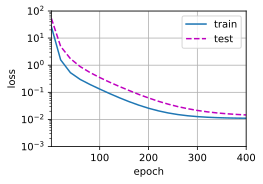

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.1666546 3.888963 ]]


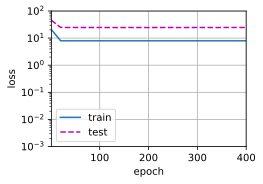

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.962818    1.283063   -3.2508929   5.23291    -0.41868514  1.0414181
   0.00542466 -0.08045164  0.00532151 -0.13293079  0.0777415  -0.19546846
   0.09143084 -0.10264269 -0.00980715  0.18290247 -0.04994195  0.11745784
   0.03522208 -0.11859412]]


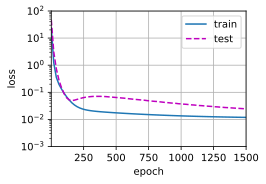

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)